<a href="https://colab.research.google.com/github/hasune613/hello-world/blob/main/2020_chapter_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第9章: RNN, CNN

## 80. ID番号への変換
***
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に$1$，2番目に頻出する単語に$2$，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて$0$とせよ．

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2021-12-09 00:47:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  23.5MB/s    in 1.2s    

2021-12-09 00:47:54 (23.5 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
!wc -l ./newsCorpora.csv

422937 ./newsCorpora.csv


In [ ]:
!head -10 ./newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive

MyDrive


In [ ]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('./newsCorpora_re.csv',header = None, sep='\t',names = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

In [ ]:
df['PUBLISHER'].value_counts(sort=True).index[0:10]

Index(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com',
       'Daily Mail', 'NASDAQ', 'Examiner.com', 'Los Angeles Times',
       'GlobalPost', 'RTT News'],
      dtype='object')

In [ ]:
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com',
       'Daily Mail']),['TITLE','CATEGORY']]

In [ ]:
df.head()

,TITLE,CATEGORY
12,Europe reaches crunch point on banking union,b
13,ECB FOCUS-Stronger euro drowns out ECB's messa...,b
19,"Euro Anxieties Wane as Bunds Top Treasuries, S...",b
20,Noyer Says Strong Euro Creates Unwarranted Eco...,b
29,REFILE-Bad loan triggers key feature in ECB ba...,b


In [ ]:
train,valid_test = train_test_split(df,test_size = 0.2, random_state = 123, shuffle=True,stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size= 0.5, random_state=123, shuffle=True, stratify=valid_test['CATEGORY'])
train.reset_index(drop=True, inplace = True)
valid.reset_index(drop=True, inplace = True)
test.reset_index(drop=True, inplace = True)

print('【学習データ】')
print(train['CATEGORY'].value_counts())
# print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [ ]:
from collections import defaultdict
import string

In [ ]:
d = defaultdict(int)

table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1 #単語カウント
d = sorted(d.items(), key = lambda x:x[1], reverse = True)#keyに単語カウントを指定,items()で単語とカウント数を取り出す（降順）
d[:5]#上位5を取り出し

[('to', 2130), ('s', 1901), ('in', 1425), ('on', 1077), ('UPDATE', 1046)]

In [ ]:
word2id = {word : i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1} # 出現頻度が2回以上の単語を登録, 単語:index=順位(0始まり)＋1

print(f'ID数 : {len(set(word2id.values()))}\n')
print('---頻度上位5語---')
for key in list(word2id)[:5]: #listだと['to', 's', 'in', 'on', 'UPDATE...]が返ってくる
  print(f'{key}:{word2id[key]}') #word2id[key]→上で取り出したkey(toとかsとか)をもとにword2idのvalue(i+1)を取り出す

ID数 : 9405

---頻度上位5語---
to:1
s:2
in:3
on:4
UPDATE:5


In [ ]:
def tokenizer(text, word2id=word2id,unk=0):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word,unk) for word in text.translate(table).split()]

In [ ]:
train.iloc[[1]]

,TITLE,CATEGORY
1,Amazon Plans to Fight FTC Over Mobile-App Purc...,t


In [ ]:
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'テキスト : {text}')
print(f'ID列 : {tokenizer(text)}')

テキスト : Amazon Plans to Fight FTC Over Mobile-App Purchases
ID列 : [169, 539, 1, 683, 1237, 82, 279, 1898, 4199]


In [ ]:
word2id.get('Amazon')

169

In [ ]:
word2id.get('Plans')

539

## 81. RNNによる予測
***
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．

$
\overrightarrow h_0 = 0, \\
\overrightarrow h_t = {\rm \overrightarrow{RNN}}(\mathrm{emb}(x_t), \overrightarrow h_{t-1}), \\
y = {\rm softmax}(W^{(yh)} \overrightarrow h_T + b^{(y)})
$

ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow h_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，${\rm \overrightarrow{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット${\rm \overrightarrow{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．

$
{\rm \overrightarrow{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$

ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

In [ ]:
import torch
from torch import nn

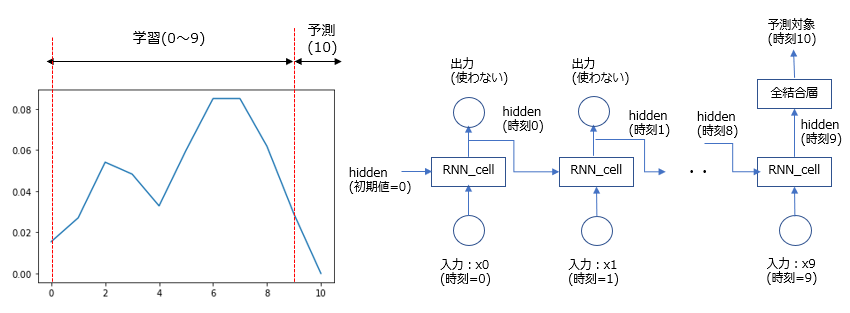

In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size,emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size,hidden_size,nonlinearity='tanh',batch_first=True)
    self.fc = nn.Linear(hidden_size,output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()#h0のゼロベクトル作成
    emb = self.emb(x) # emb.size() = (batch_size,seq_len,emb_size)
    out,hidden = self.rnn(emb,hidden)
    out = self.fc(out[:, -1,:])
    return out

  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size)
    return hidden


In [ ]:
from torch.utils.data import Dataset

In [ ]:
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self): #len(Dataset)で返す値を指定
     return len(self.y)
     
  def __getitem__(self,index):# Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer(text)
    return {
        'inputs' : torch.tensor(inputs, dtype = torch.int64),
        'labels' : torch.tensor(self.y[index],dtype=torch.int64)
    }

In [ ]:
category_dict = {'b' : 0 ,'t' :  1, 'e' : 2, 'm' : 3}
y_train = train.CATEGORY.map(lambda x : category_dict[x]).values
y_valid = valid.CATEGORY.map(lambda x : category_dict[x]).values
y_test = test.CATEGORY.map(lambda x : category_dict[x]).values

dataset_train = CreateDataset(train.TITLE,y_train,tokenizer)
dataset_valid = CreateDataset(valid.TITLE,y_valid,tokenizer)
dataset_test = CreateDataset(test.TITLE,y_test,tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力')
for var in dataset_train[1]:
  print(f'{var} : {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力
inputs : tensor([ 169,  539,    1,  683, 1237,   82,  279, 1898, 4199])
labels : 1


In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2238, 0.2168, 0.3413, 0.2180]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1497, 0.2891, 0.2802, 0.2810]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3086, 0.2487, 0.3180, 0.1248]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2130, 0.2727, 0.2818, 0.2325]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4515, 0.2040, 0.2021, 0.1424]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3539, 0.2656, 0.2401, 0.1403]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2728, 0.2301, 0.2882, 0.2089]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3809, 0.0810, 0.1955, 0.3427]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1910, 0.2638, 0.3092, 0.2359]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2914, 0.2181, 0.3276, 0.1629]], grad_fn=<SoftmaxBackward0>)


## 82. 確率的勾配降下法による学習
***
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [ ]:
from torch.utils.data import DataLoader
import time
from torch import optim

In [ ]:
def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(dataset), correct / total

In [ ]:
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn= None, device = None):
  model.to(device)

  dataloader_train = DataLoader(dataset_train,batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid,batch_size=1, shuffle=False)
  # スケジューラの設定（学習率を学習の途中で変化）
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs,eta_min=1e-5, last_epoch=-1)

  log_train = []
  log_valid = []

  for epoch in range(num_epochs):
    s_time = time.time()

    model.train()

    for data in dataloader_train:
      optimizer.zero_grad()

      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs , labels)
      loss.backward()
      optimizer.step()
    
    model.eval()
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    e_time = time.time()

    print(f'epoch : {epoch+1},loss_train : {loss_train:.4f},acc_train : {acc_train:.4f}, loss_valid : {loss_valid:.4f}, acc_valid : {acc_valid:.4f},{(e_time - s_time):.4f}sec')

    if epoch > 2 and log_valid[epoch-3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch -1][0]<= log_valid[epoch][0]:
      break

    scheduler.step()
  return {'train' : log_train, 'valid' : log_valid} 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def visualize_logs(log):
  fig,ax = plt.subplots(1,2,figsize = (8,4))
  ax[0].plot(np.array(log['train']).T[0],label='train',c ='c',linestyle = "dashed")
  ax[0].plot(np.array(log['valid']).T[0],label='valid',c ='gray')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1],label='train',c ='c',linestyle = "dashed")
  ax[1].plot(np.array(log['valid']).T[1],label='valid',c ='gray')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()


In [ ]:
# VOCAB_SIZE = len(set(word2id.values())) +1
# EMB_SIZE = 300
# PADDING_IDX = len(set(word2id.values()))
# OUTPUT_SIZE = 4
# HIDDEN_SIZE = 50
# LEARNING_RATE =1e-3
# BATCH_SIZE = 1
# NUM_EPOCHS = 3

# model = RNN(VOCAB_SIZE ,EMB_SIZE,PADDING_IDX,OUTPUT_SIZE,HIDDEN_SIZE)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(),lr = LEARNING_RATE)

# log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer,NUM_EPOCHS)


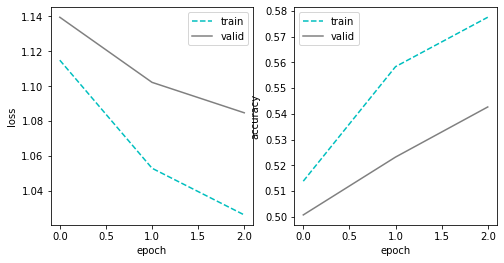

In [ ]:
visualize_logs(log)


In [ ]:
_, acc_train = calculate_loss_and_acuuracy(model, dataset_train )
_, acc_test = calculate_loss_and_acuuracy(model, dataset_test )
print(f'正解率(学習データ),{acc_train:.4f}')
print(f'正解率(評価データ),{acc_test:.4f}')

正解率(学習データ),0.5775
正解率(評価データ),0.5427


## 83. ミニバッチ化・GPU上での学習
***
問題82のコードを改変し，$B$事例ごとに損失・勾配を計算して学習を行えるようにせよ（$B$の値は適当に選べ）．また，GPU上で学習を実行せよ．

In [ ]:
class Padsequence():
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x : x['inputs'].shape[0],reverse=True) #バッチ内の文章の単語数（系列長）の多い順に並べ替える
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True,padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs':sequences_padded, 'labels' : labels}

In [ ]:
# VOCAB_SIZE = len(set(word2id.values())) +1
# EMB_SIZE = 300
# PADDING_IDX = len(set(word2id.values()))
# OUTPUT_SIZE = 4
# HIDDEN_SIZE = 50
# LEARNING_RATE =5e-2
# BATCH_SIZE = 32
# NUM_EPOCHS = 3

# model = RNN(VOCAB_SIZE ,EMB_SIZE,PADDING_IDX,OUTPUT_SIZE,HIDDEN_SIZE)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(),lr = LEARNING_RATE)

# device = torch.device('cpu')
# log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer,NUM_EPOCHS,collate_fn = Padsequence(PADDING_IDX),device=device)


epoch : 1,loss_train : 1.2579,acc_train : 0.4166, loss_valid : 1.2813, acc_valid : 0.4027,9.6604sec
epoch : 2,loss_train : 1.1548,acc_train : 0.5025, loss_valid : 1.1782, acc_valid : 0.4858,9.4802sec
epoch : 3,loss_train : 1.0983,acc_train : 0.5594, loss_valid : 1.1132, acc_valid : 0.5367,9.6670sec


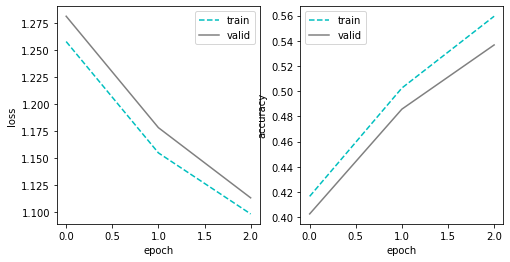

正解率(学習データ)0.5594
正解率(テストデータ)0.5554


In [ ]:
visualize_logs(log)
_, acc_train = calculate_loss_and_acuuracy(model,dataset_train,device)
_, acc_test= calculate_loss_and_acuuracy(model,dataset_test,device)

print(f'正解率(学習データ){acc_train:.4f}')
print(f'正解率(テストデータ){acc_test:.4f}')


## 84. 単語ベクトルの導入
***
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込み$emb(x)$を初期化し，学習せよ．

In [ ]:
# # 学習済み単語ベクトルのダウンロード
# FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
# FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt

--2021-12-08 04:14:46--  https://docs.google.com/uc?export=download&confirm=&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving docs.google.com (docs.google.com)... 142.250.103.139, 142.250.103.138, 142.250.103.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.103.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors-     [ <=>                ]   3.05K  --.-KB/s    in 0s      

2021-12-08 04:14:47 (19.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [3121]



In [ ]:
from gensim.models import KeyedVectors

In [ ]:
model = KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0

for i, word in enumerate(word2id.keys()):
  try:#エラーになるかもしれないが、実行させたい処理
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:#KeyErrorとなったら、下記の処理をする
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE))

weights = torch.from_numpy(weights.astype((np.float32)))

print(weights.dtype)
print(f'学習済みベクトル利用単語数：{words_in_pretrained} / {VOCAB_SIZE}')#学習済みベクトル内にあった単語数/もともとの文章の中の単語数
print(weights.size())



torch.float32
学習済みベクトル利用単語数：9174 / 9406
torch.Size([9406, 300])


In [ ]:
class RNN(nn.Module):
  def __init__(self,vocab_size,emb_size, padding_idx, output_size,hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1
    if emb_weights !=None:
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)

    self.rnn = nn.RNN(emb_size, hidden_size, num_layers,nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()#h0のゼロベクトル作成
    emb = self.emb(x) #emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden) # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:,-1,:]) # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions,self.batch_size, self.hidden_size)
    return hidden




In [ ]:
VOCAB_SIZE = len(set(word2id.values())) +1 #9405 + 1(PADDING_IDXで1つindex番号を使った分追加)
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) #9405
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE =5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 3
# PADDING_IDX　- > 9405

model = RNN(VOCAB_SIZE ,EMB_SIZE,PADDING_IDX,OUTPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,emb_weights=weights)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = LEARNING_RATE)

device = torch.device('cpu')
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer,NUM_EPOCHS,collate_fn = Padsequence(PADDING_IDX),device=device)


epoch : 1,loss_train : 1.1703,acc_train : 0.4234, loss_valid : 1.1686, acc_valid : 0.4356,7.8848sec
epoch : 2,loss_train : 1.1789,acc_train : 0.4308, loss_valid : 1.1953, acc_valid : 0.4296,7.7352sec
epoch : 3,loss_train : 1.1716,acc_train : 0.4675, loss_valid : 1.2036, acc_valid : 0.4536,7.8325sec


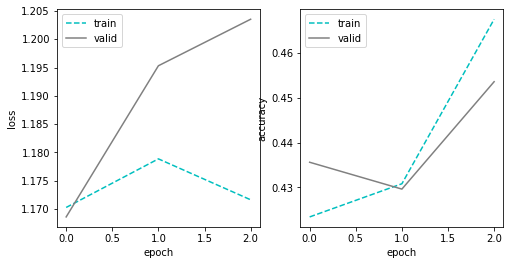

正解率(学習データ) : 0.468
正解率(評価データ) : 0.446


In [ ]:
visualize_logs(log)

_, acc_train = calculate_loss_and_acuuracy(model,dataset_train, device)
_,acc_test = calculate_loss_and_acuuracy(model, dataset_test,device)
print(f'正解率(学習データ) : {acc_train:.3f}')
print(f'正解率(評価データ) : {acc_test:.3f}')

## 85. 双方向RNN・多層化
***
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

$
\overleftarrow h_{T+1} = 0, \\
\overleftarrow h_t = {\rm \overleftarrow{RNN}}(\mathrm{emb}(x_t), \overleftarrow h_{t+1}), \\
y = {\rm softmax}(W^{(yh)} [\overrightarrow h_T; \overleftarrow h_1] + b^{(y)})
$

ただし，$\overrightarrow h_t \in \mathbb{R}^{d_h}, \overleftarrow h_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，${\rm \overleftarrow{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．

In [ ]:
VOCAB_SIZE = len(set(word2id.values())) +1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 3

model = RNN(VOCAB_SIZE,EMB_SIZE,PADDING_IDX,OUTPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,emb_weights=weights, bidirectional=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr= LEARNING_RATE)

deviece = torch.device('cpu')
log = train_model(dataset_train,dataset_valid,BATCH_SIZE,model,criterion,optimizer,NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX),device=device)

epoch : 1,loss_train : 1.1925,acc_train : 0.3983, loss_valid : 1.2194, acc_valid : 0.3967,15.1453sec
epoch : 2,loss_train : 1.1261,acc_train : 0.4978, loss_valid : 1.1463, acc_valid : 0.4888,14.7947sec
epoch : 3,loss_train : 1.0619,acc_train : 0.5783, loss_valid : 1.0773, acc_valid : 0.5801,14.7559sec


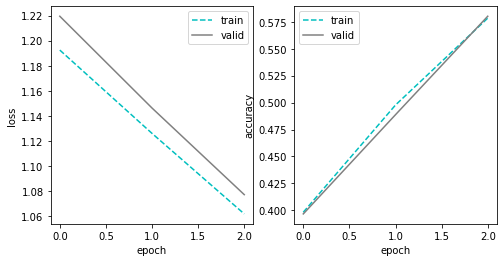

正解率（学習データ）：0.578
正解率（評価データ）：0.566


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 86. 畳み込みニューラルネットワーク (CNN)
***
ID番号で表現された単語列$\boldsymbol x = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol x$からカテゴリ$y$を予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．

+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現
 すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．

$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
$]

ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．
最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．

$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$

 最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．

$
y = {\rm softmax}(W^{(yc)} c + b^{(y)})
$

なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．

## 図1:
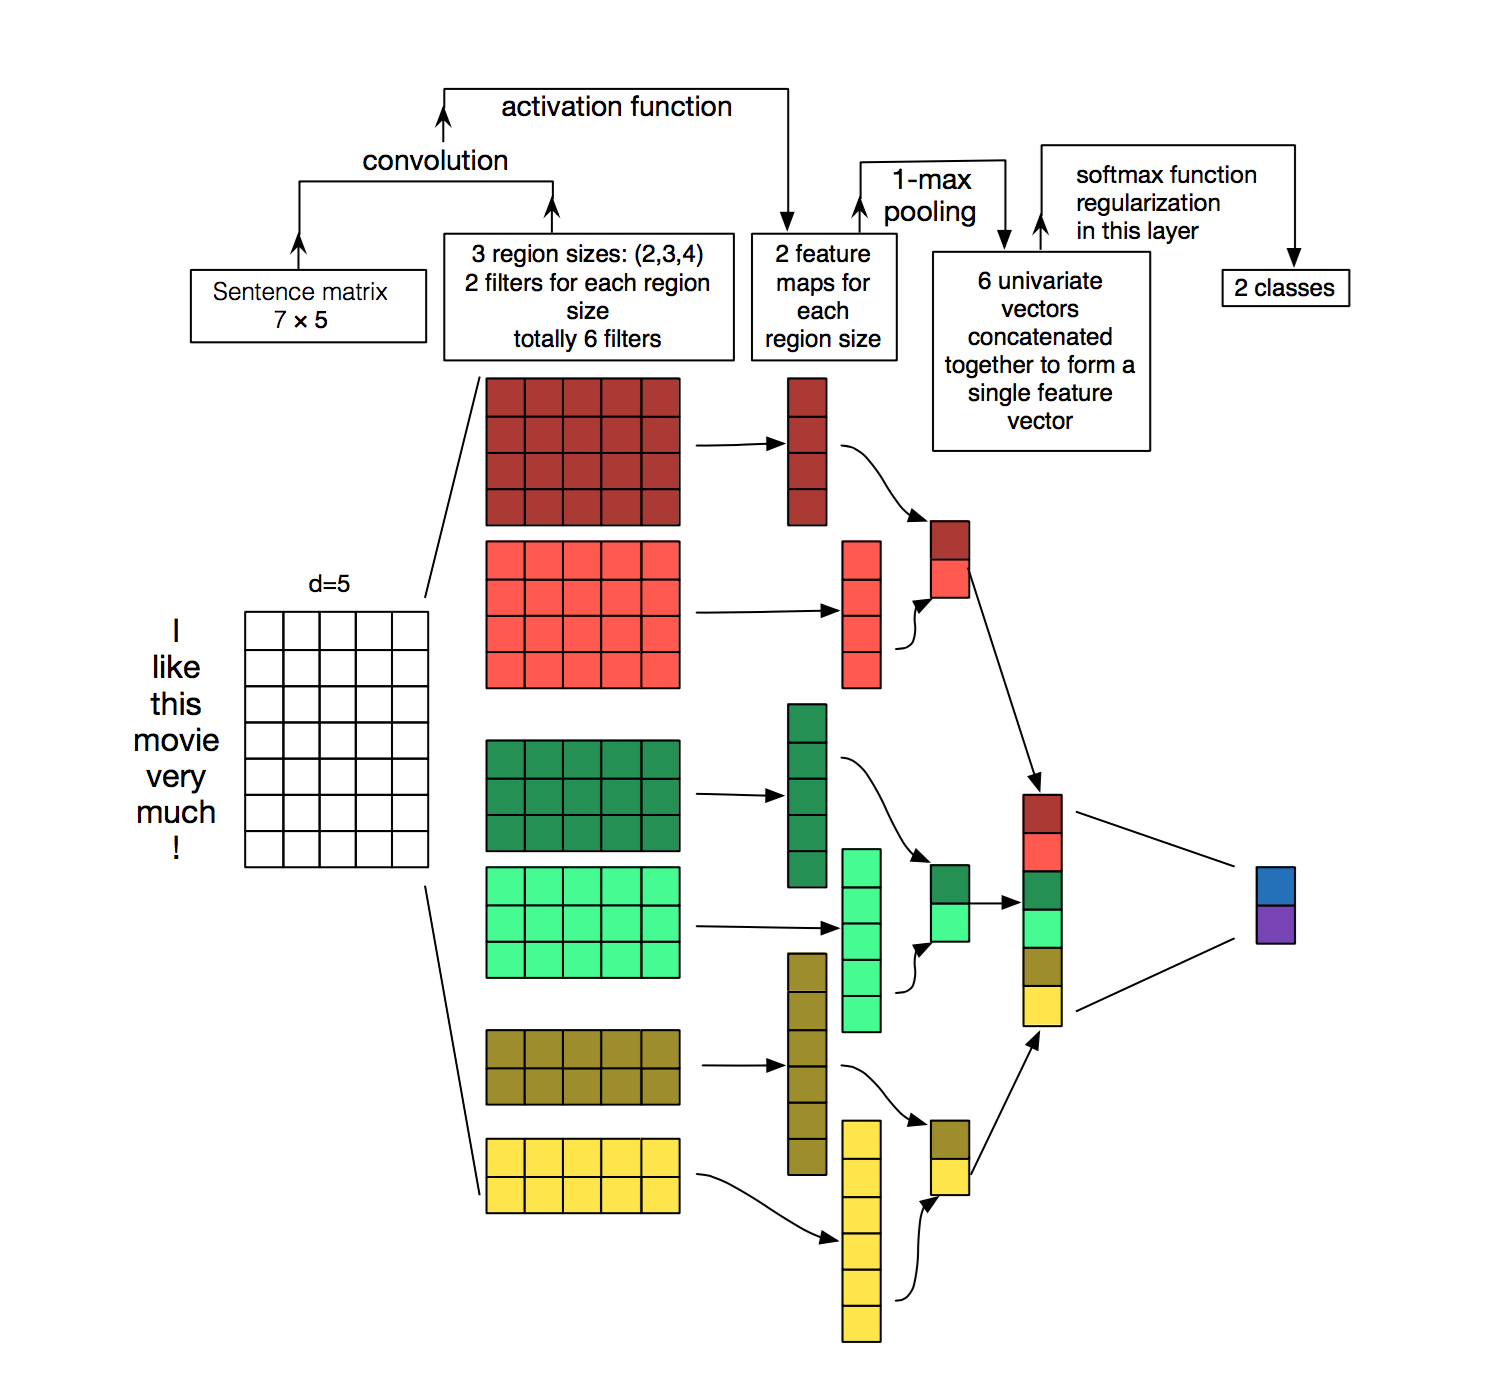

## 図2
#### 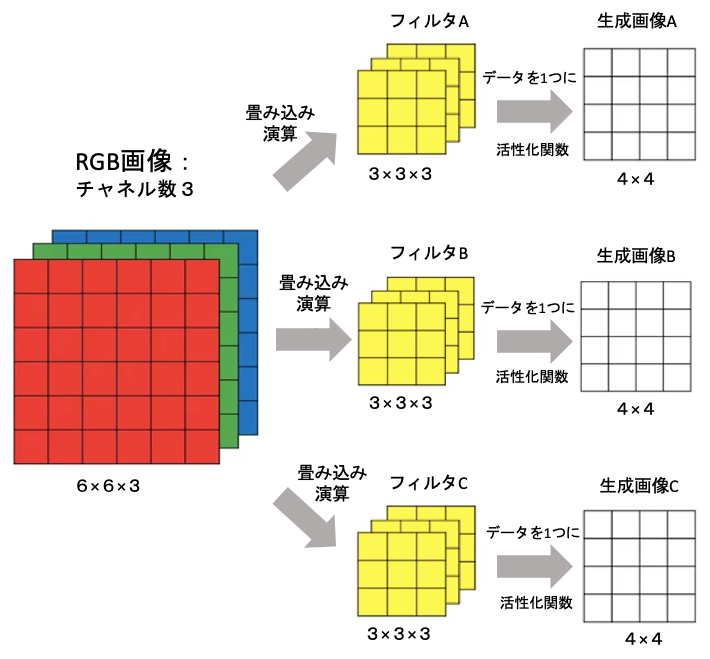

## 図3
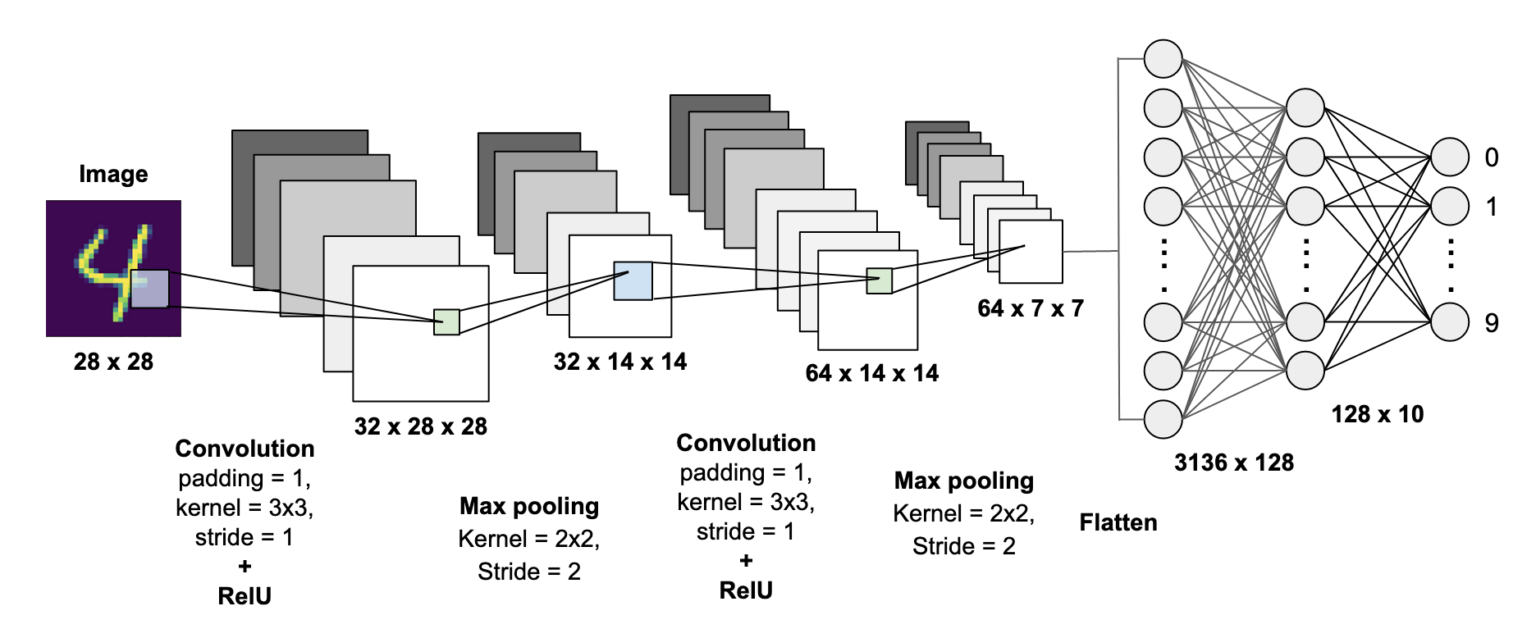

## 図4
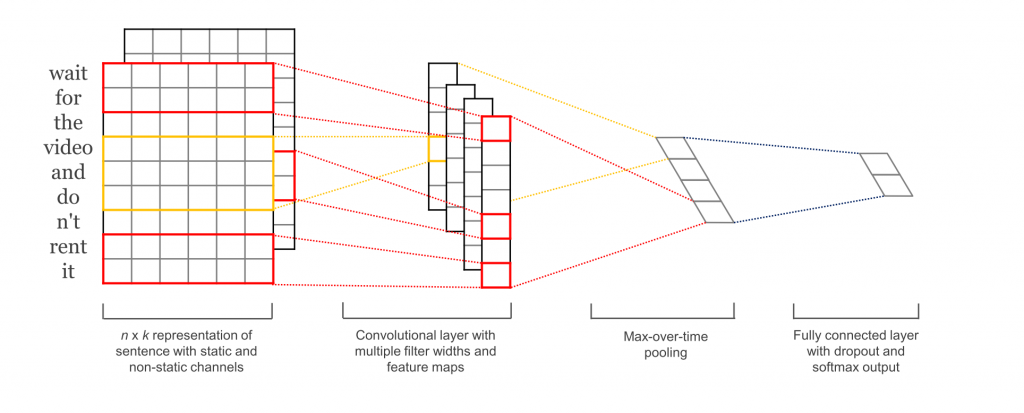

## 図5
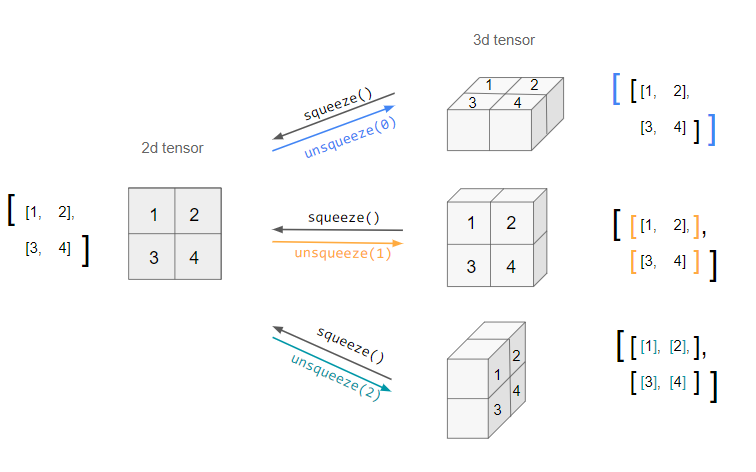

## 図6
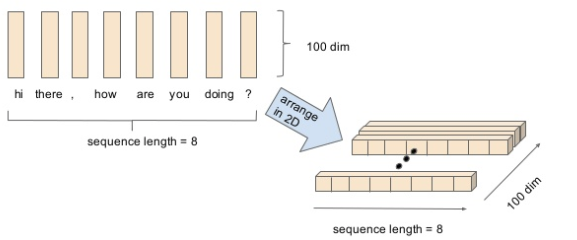

In [ ]:
from torch.nn import functional as F

In [ ]:
class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights,stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1,out_channels, (kernel_heights,emb_size),stride, (padding,0))
    #nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=上下に1つずつpaddingして、左右にはなし?))
    #in_channels入力チャネル数　RGBでは3
    #out_channels畳み込みをした後のチャネル数、フィルタ数
    #kernel_size カーネルの大きさ
    #stride カーネルをどれくらい移動させるか
    #padding パディングの大きさ,1指定で両端に挿入するので2だけ大きくなる、デフォルトは0
    self.drop = nn.Dropout(0.3) #一定の確率でランダムにニューロンを無視。正則化の一種。
    self.fc = nn.Linear(out_channels,output_size)#Linearは「全結合層」

  def forward(self, x): #x.size() -> (batch_size,, seq_len)
    emb = self.emb(x).unsqueeze(1)#指定のdimに1次元増やす
    #emb.size() -> (batcy_size, 1(unsqueeze), seq_len, emb_size)
    conv = self.conv(emb)
    #conv.size() -> (batch_size, output_channeles,seq_len,1)
    act = F.relu(conv.squeeze(3))
    #act.size() -> (batch_size, output_channeles, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    #max_pool.size -> (batch_size, output_channeles, 1) seq_len方向に最大値を取得
    #図3の最後から3番目
    out = self.fc(self.drop(max_pool.squeeze(2)))
    #output.size() -> (batch_size, out_size)
    return out


*  H,W = 入力サイズ
* F = フィルタサイズ
* P = パディング
* S = ストライド

$$  O_h =\dfrac{H + 2P - F_h }{S} +1 $$
$$ $$
$$  O_w =\dfrac{W + 2P - F_w }{S} +1$$ 
$$ $$

### *入力サイズ4×4、フィルタサイズ2×2、パディング0、ストライド2の場合*

$$  O_h =\dfrac{4 + 0(2*0) - 2 }{2} +1 =2 $$
$$ $$
$$  O_w =\dfrac{4 + 0(2*0) -2 }{2} +1 =2 $$ 

In [ ]:
VOCAB_SIZE = len(set(word2id.values())) + 1#辞書のID + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

model = CNN(VOCAB_SIZE,EMB_SIZE,PADDING_IDX,OUTPUT_SIZE,OUT_CHANNELS,KERNEL_HEIGHTS,STRIDE,PADDING,emb_weights=weights)

for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2304, 0.2671, 0.2535, 0.2489]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2455, 0.2465, 0.2682, 0.2398]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2542, 0.2479, 0.2618, 0.2361]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2736, 0.2317, 0.2447, 0.2500]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2709, 0.2379, 0.2575, 0.2338]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2772, 0.1978, 0.2854, 0.2396]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2542, 0.2372, 0.2493, 0.2593]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2419, 0.2567, 0.2533, 0.2481]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2433, 0.2250, 0.2371, 0.2946]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2592, 0.2210, 0.2521, 0.2677]], grad_fn=<SoftmaxBackward0>)


## 87. 確率的勾配降下法によるCNNの学習
***
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [ ]:
VOCAB_SIZE = len(set(word2id.values())) + 1#辞書のID + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_ChANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 3

model = CNN(VOCAB_SIZE,EMB_SIZE,PADDING_IDX,OUTPUT_SIZE,OUT_ChANNELS,KERNEL_HEIGHTS,STRIDE,PADDING,emb_weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= LEARNING_RATE)
device = torch.device('cuda')

log = train_model(dataset_train,dataset_valid,BATCH_SIZE,model,criterion, optimizer,NUM_EPOCHS,collate_fn = Padsequence(PADDING_IDX), device=device)

epoch : 1,loss_train : 1.0638,acc_train : 0.5740, loss_valid : 1.0767, acc_valid : 0.5734,11.6468sec
epoch : 2,loss_train : 1.0033,acc_train : 0.6284, loss_valid : 1.0252, acc_valid : 0.6355,11.6999sec
epoch : 3,loss_train : 0.9805,acc_train : 0.6434, loss_valid : 1.0033, acc_valid : 0.6437,11.6214sec


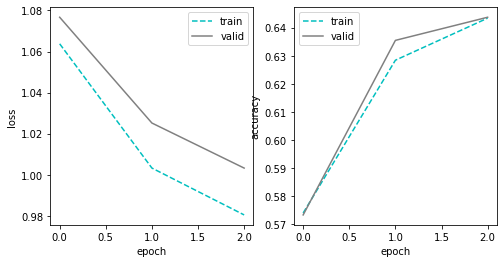

正解率（学習データ）: 0.6434
正解率（評価データ）: 0.6400


In [ ]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)

print(f'正解率（学習データ）: {acc_train:.4f}')
print(f'正解率（評価データ）: {acc_test:.4f}')

## 88. パラメータチューニング
***
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 26.7 MB/s 
     |████████████████████████████████| 80 kB 9.5 MB/s 
     |████████████████████████████████| 209 kB 78.0 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 112 kB 54.7 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 149 kB 45.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=74a75ad2d190c292b1f0229377d0fb61214d103f337957278830330d695db7b6
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

In [ ]:
class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)
    #nn.Linear(後にCONV_PARAMSで3種類設定しているのでlen(conv_oarams)==3,out_channelsは後にsuggest_discrete_uniformoutで50～200間から50と指定されている
    #output_size == 4
    
  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb)).squeeze(3) for i, conv in enumerate(self.convs)]
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out
                

In [ ]:


def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = trial.suggest_int('emb_size', 100, 400, 100)
  out_channels = trial.suggest_int('out_channels', 50, 200, 50)
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size =  trial.suggest_int('batch_size', 16, 128, 16)

  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 1

  # モデルの定義
  model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.device('cuda')

  # モデルの学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失の算出
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion) 

  return loss_valid 

In [ ]:
study = optuna.create_study()
study.optimize(objective, timeout = 60)

print('Best trial')
trial = study.best_trial
print(f'Value: {trial.value:.4f}')
print('Params:')
for key , value in trial.params.items():
  print(f'{key}:{value}')

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = int(trial.params['emb_size'])
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = int(trial.params['out_channels'])
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
DROP_RATE = trial.params['drop_rate']
LEARNING_RATE = trial.params['learning_rate']
BATCH_SIZE = int(trial.params['batch_size'])
NUM_EPOCHS = 30

# モデルの定義
model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
print(model)

textCNN(
  (emb): Embedding(9406, 300, padding_idx=9405)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(3, 100), stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 200, kernel_size=(4, 100), stride=(1, 1), padding=(2, 0))
  )
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=600, out_features=4, bias=True)
)


In [ ]:

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

In [ ]:
visualize_logs(log)
_, acc_train = calculate_loss_and_accuracy(model,dataset_train,device)
_, acc_valid = calculate_loss_and_accuracy(model,dataset_valid,device)
print(f'学習データ：{acc_train}')
print(f'検証データ：{acc_valid}')